<a href="https://colab.research.google.com/github/zainamri/Kelompok-3-/blob/main/clusteringg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import kurtosis
import matplotlib.pyplot as plt

# Menghubungkan Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
# Akses dataset
file_path = ('/content/drive/MyDrive/dataset/Mall_Customers.csv')
data = pd.read_csv(file_path)
X = data.drop("CustomerID", axis=1) # Menghapus kolom CustomerID dari dataset

# Menampilkan beberapa baris pertama dari dataset
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [73]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [74]:
# Periksa data kosong
if data.isnull().sum().sum() == 0:
    print("Tidak ada data kosong.")
else:
    print(data.isnull().sum())


Tidak ada data kosong.


## Langkah 2: Encode Variabel Kategorikal

In [75]:
# Encode variabel kategorikal
le = LabelEncoder()
X["Genre"] = le.fit_transform(X["Genre"])  # Mengubah kolom Genre menjadi nilai numerik

# Langkah 3: Mengatur Skala Fitur

In [76]:
# Skala fitur
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Mengubah skala fitur antara 0 dan 1

# Langkah 4: Menghitung Bobot Fitur Komposit

In [77]:
# Hitung bobot fitur komposit berdasarkan varians dan kurtosis
feature_variances = np.var(X_scaled, axis=0)  # Menghitung varians setiap fitur
feature_kurtosis = np.abs(kurtosis(X_scaled, axis=0))  # Menghitung kurtosis setiap fitur

# Normalisasi bobot
normalized_variances = feature_variances / np.sum(feature_variances)  # Normalisasi varians
normalized_kurtosis = feature_kurtosis / np.sum(feature_kurtosis)  # Normalisasi kurtosis

# Hitung bobot komposit
composite_weights = normalized_variances * normalized_kurtosis  # Menghitung bobot komposit
normalized_composite_weights = composite_weights / np.sum(composite_weights)  # Normalisasi bobot komposit

## Langkah 5: Terapkan Pembobotan Fitur  

In [78]:
# Terapkan pembobotan fitur
X_weighted = X_scaled * normalized_composite_weights  # Mengalikan fitur yang telah diskalakan dengan bobot komposit

# Langkah 6: Definisikan Rentang Parameter untuk Pencarian Grid  


In [79]:
# Pencarian grid untuk gamma dan k yang optimal
gamma_range = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]  # Rentang nilai gamma untuk kernel RBF
K_range = range(2, 11)  # Rentang nilai k untuk clustering K-Means
best_score = -1  # Inisialisasi skor terbaik
best_gamma = None  # Inisialisasi gamma terbaik
best_k = None  # Inisialisasi k terbaik
best_clusters = None  # Inisialisasi kluster terbaik

# Langkah 7: Lakukan Pencarian Grid untuk Menemukan Parameter Optimal  


In [80]:
for gamma in gamma_range:
    K = rbf_kernel(X_weighted, gamma=gamma)  # Transformasi fitur berbobot menggunakan kernel RBF
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Inisialisasi model KMeans
        kmeans.fit(K)  # Melatih model KMeans
        score = silhouette_score(K, kmeans.labels_)  # Menghitung skor siluet
        if score > best_score:  # Memperbarui skor terbaik jika skor saat ini lebih baik
            best_score = score
            best_gamma = gamma
            best_k = k
            best_clusters = kmeans.labels_

# Langkah 8: Terapkan Transformasi Kernel RBF dengan Gamma Terbaik  


In [81]:
# Terapkan transformasi kernel RBF dengan gamma terbaik
K = rbf_kernel(X_weighted, gamma=best_gamma)  # Transformasi ulang dengan gamma terbaik

# Langkah 9: Kurangi Dimensionalitas untuk Visualisasi  


In [82]:
# Kurangi dimensionalitas untuk visualisasi
pca = PCA(n_components=2)  # Inisialisasi PCA untuk reduksi dimensi
X_pca = pca.fit_transform(K)  # Mengubah data ke dalam dua komponen utama

# Langkah 10: Plot Hasil Clustering  


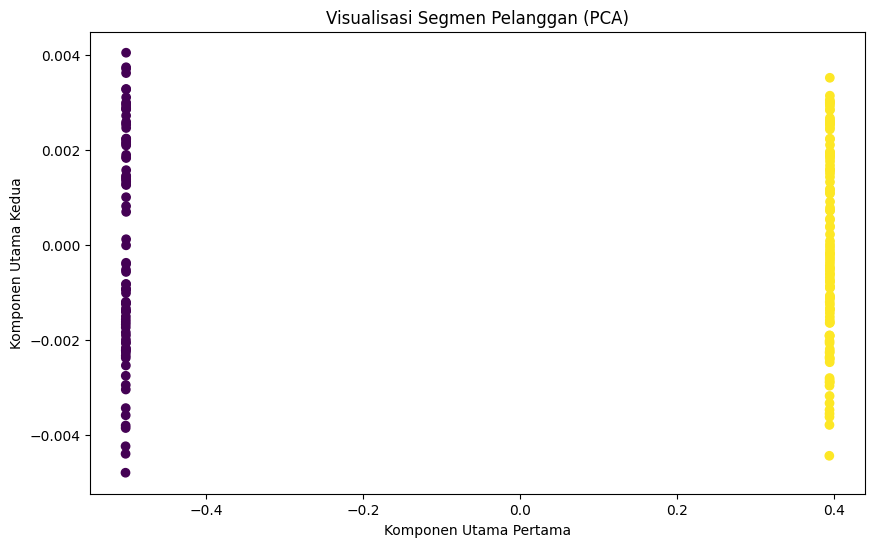

In [83]:
# Plot hasil
plt.figure(figsize=(10, 6))  # Mengatur ukuran plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_clusters, cmap="viridis")  # Membuat scatter plot
plt.title("Visualisasi Segmen Pelanggan (PCA)")  # Judul plot
plt.xlabel("Komponen Utama Pertama")  # Label sumbu x
plt.ylabel("Komponen Utama Kedua")  # Label sumbu y

# Tampilkan plot di notebook Jupyter
plt.show()  # Menampilkan plot  # This will display the plot inline

# Create output directory if it doesn't exist
plt.savefig("/content/drive/MyDrive/dataset/cluster-visual.png")
plt.close()


# Langkah 11: Cetak Hasil Clustering Akhir  


In [84]:
# Periksa apakah solusi clustering yang valid ditemukan
if best_score > -1:
    # Cetak skor siluet terbaik yang dicapai
    print(f"Skor Siluet Terbaik: {best_score:.4f}")
    # Cetak nilai gamma yang menghasilkan skor terbaik
    print(f"Gamma Terbaik: {best_gamma}")
    # Cetak jumlah kluster yang menghasilkan skor terbaik
    print(f"Jumlah Kluster: {best_k}")
else:
    # Beri tahu pengguna jika tidak ada solusi clustering yang valid ditemukan
    print("Tidak ada solusi clustering yang valid ditemukan")

Skor Siluet Terbaik: 0.9963
Gamma Terbaik: 0.1
Jumlah Kluster: 2


# Langkah 12: Simpan Penugasan Kluster  


In [85]:
# Simpan penugasan kluster
data["Cluster"] = best_clusters  # Menambahkan kolom Cluster ke DataFrame
data[["CustomerID", "Cluster"]].to_csv("/content/drive/MyDrive/dataset/submission.csv", index=False)

In [86]:
# Memilih fitur untuk clustering
features = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Menerapkan KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0)
data['Cluster'] = kmeans.fit_predict(features)

In [87]:
from sklearn.preprocessing import LabelEncoder

# Mengimpor LabelEncoder untuk mengonversi kolom 'Genre' menjadi numerik lagi
label_encoder = LabelEncoder()
data['Genre'] = label_encoder.fit_transform(data['Genre'])


Cluster 0 Mean Values:
CustomerID                96.982609
Genre                      0.434783
Age                       46.165217
Annual Income (k$)        59.365217
Spending Score (1-100)    32.886957
Cluster                    0.000000
dtype: float64

Cluster 1 Mean Values:
CustomerID                105.258824
Genre                       0.447059
Age                        28.952941
Annual Income (k$)         62.176471
Spending Score (1-100)     73.623529
Cluster                     1.000000
dtype: float64


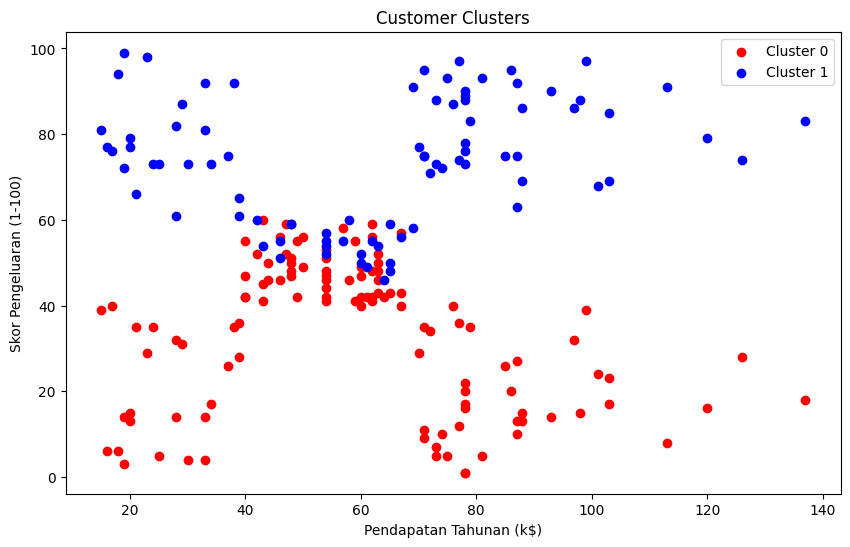

In [88]:
# Menganalisis karakteristik pelanggan di cluster 0 dan cluster 1
cluster_0 = data[data['Cluster'] == 0]
cluster_1 = data[data['Cluster'] == 1]

# Menghitung nilai rata-rata untuk setiap cluster
cluster_0_mean = cluster_0.mean()
cluster_1_mean = cluster_1.mean()

# Mencetak nilai rata-rata untuk setiap cluster
print("Cluster 0 Mean Values:")
print(cluster_0_mean)
print("\nCluster 1 Mean Values:")
print(cluster_1_mean)

# Memvisualisasikan cluster
plt.figure(figsize=(10, 6))
plt.scatter(cluster_0['Annual Income (k$)'], cluster_0['Spending Score (1-100)'], color='red', label='Cluster 0')
plt.scatter(cluster_1['Annual Income (k$)'], cluster_1['Spending Score (1-100)'], color='blue', label='Cluster 1')
plt.xlabel('Pendapatan Tahunan (k$)')
plt.ylabel('Skor Pengeluaran (1-100)')
plt.title('Customer Clusters')
plt.legend()
plt.show()

Analisis
Cluster 0: Pelanggan di cluster ini cenderung lebih tua (rata-rata 46 tahun) dan memiliki skor pengeluaran yang lebih rendah (32.89), meskipun pendapatan tahunan mereka cukup baik (59.37k$).

Cluster 1: Pelanggan di cluster ini lebih muda (rata-rata 29 tahun) dan memiliki skor pengeluaran yang jauh lebih tinggi (73.62), dengan pendapatan tahunan yang sedikit lebih tinggi (62.18k$).